In [53]:
#use niwrap3912 conda environment
import os
import yaspy
import scipy.io
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import zscore
from matplotlib.colors import ListedColormap


In [54]:
'''
#just get the labeling data from the MATLAB file (scholtens2018neuroimage_economo.mat, which is provided by the paper)
#Data from this paper: "An MRI Von Economo – Koskinas atlas" (Scholtens et al., 2018)
#They provide a matlab file with the "regionDescriptions"... so since parcellation is much harder from their volumentric data and freesurefer file
#use the easier way to do..
#But before using this data, make sure to convert the regionDescriptions (which is in stirng array in the struct) to a "char" array 
#because the scipy.io cannot load the string array correctly as it is not supported in the scipy.io.loadmat function
#then you can load the field as it is.
#load matlab file scholtens2018neuroimage_economo.mat. 

economo_mat = scipy.io.loadmat('scholtens2018neuroimage_economo_tochar.mat')
region_descriptions = [str(desc) for desc in economo_mat['ECONOMO_43']['regionDescriptions'][0][0]]
#remove the empty characters in each desciption (meaning remove empty spaces in each description
region_descriptions = [desc.strip() for desc in region_descriptions]

#calculate cell size
#Whereas cell size was calculated according to [H mean x W mean ]; 
#with H mean (Height) = [H (min-max) /2] and W mean (Width) = [W (min-max) /2] per individual cortical layer and then averaged across all layers.
#H is layer1total_thickness_dome
#W is layer1total_thickness_wall )

#save the cell size data to a numpy array
cell_size_data = []
for layer in ['I','II','III','IV','V','VI']:
    layer_name = f"layer{layer}"
    cell_size = economo_mat['ECONOMO_43'][f'{layer_name}total_cell_content_cellsize'][0][0]
   # print(cell_size)    
    cell_size_data.append(cell_size)
#get cell_content_cellsize from each layer (I..V) e.g., layerItotal_cell_content_cellsize from the matlab economo_mat
#then average across all layers
average_cell_size = np.nanmean(cell_size_data,axis=1)
print(average_cell_size)
'''


'\n#just get the labeling data from the MATLAB file (scholtens2018neuroimage_economo.mat, which is provided by the paper)\n#Data from this paper: "An MRI Von Economo – Koskinas atlas" (Scholtens et al., 2018)\n#They provide a matlab file with the "regionDescriptions"... so since parcellation is much harder from their volumentric data and freesurefer file\n#use the easier way to do..\n#But before using this data, make sure to convert the regionDescriptions (which is in stirng array in the struct) to a "char" array \n#because the scipy.io cannot load the string array correctly as it is not supported in the scipy.io.loadmat function\n#then you can load the field as it is.\n#load matlab file scholtens2018neuroimage_economo.mat. \n\neconomo_mat = scipy.io.loadmat(\'scholtens2018neuroimage_economo_tochar.mat\')\nregion_descriptions = [str(desc) for desc in economo_mat[\'ECONOMO_43\'][\'regionDescriptions\'][0][0]]\n#remove the empty characters in each desciption (meaning remove empty spaces 

In [55]:
# Load von Economo-Koskinas atlas from MYATLAS package
# This atlas is already mapped to 32k fsLR space (from Foit et al., 2022)

# Define cytoarchitectonic type colors and names
CYTO5_COLORS = {
    'Agranular': '#3478F6',   # Blue
    'Frontal': '#FFB6FF',     # Pink
    'Parietal': '#66FF66',    # Green  
    'Polar': '#FFFF66',       # Yellow
    'Granular': '#9966FF'     # Purple
}
CYTO5_NAME = list(CYTO5_COLORS.keys())

# Set paths for von Economo atlas files
myatlas_base_path = "/Users/dennis.jungchildmind.org/Downloads/MYATLAS_package_new/"
von_ek_subpath = "maps/Surface/HCP_conte69/conte69_32k/gii/cytoarchitecture/"
von_ek_lh = "vonEK_cell_size_conte69_32k_lh.func.gii"
von_ek_rh = "vonEK_cell_size_conte69_32k_rh.func.gii"

# Load cell size data for both hemispheres
von_ek_cell_size_lh = nib.load(os.path.join(myatlas_base_path, von_ek_subpath, von_ek_lh)).darrays[0].data
von_ek_cell_size_rh = nib.load(os.path.join(myatlas_base_path, von_ek_subpath, von_ek_rh)).darrays[0].data

# Create parcellation atlas from unique cell size values
# Note: This approach estimates parcellation based on unique values at each vertex
parcel_index = np.unique(von_ek_cell_size_lh)
von_ek_atlas = np.zeros(von_ek_cell_size_lh.shape)

for i, parcel in enumerate(parcel_index):
    von_ek_atlas[von_ek_cell_size_lh == parcel] = i

# Save the parcellation atlas
template_file = nib.load(os.path.join(myatlas_base_path, von_ek_subpath, von_ek_lh))
template_file.darrays[0].data = von_ek_atlas
output_path = os.path.join(myatlas_base_path, von_ek_subpath, 'vonEK_parcellation_from_myatls_conte69_32k_lh.func.gii')
nib.save(template_file, output_path)

In [56]:
#use the atlas from the enigmatoolbox 
#needed to download from https://github.com/MICA-MNI/ENIGMA/blob/master/enigmatoolbox/datasets/parcellations/economo_koskinas_conte69.csv
#load the economo_koskinas_conte69.csv file
# this is in 32k conte (fs_LR) space

file_path = "/Users/dennis.jungchildmind.org/OneDrive - Child Mind Institute/layer_project/cortical_layer/external/economo_enigamtoolbox"
file_name = "economo_koskinas_conte69.csv"

#load the file
economo_koskinas_atlas = pd.read_csv(os.path.join(file_path, file_name), header=None).to_numpy().flatten()
#first half is the left hemisphere and the second half is the right hemisphere
economo_koskinas_atlas_lh = economo_koskinas_atlas[:32492]
economo_koskinas_atlas_rh = economo_koskinas_atlas[32492:]

#THEN save the atlas as func.gii format
#load any *.func.gii file with 32k fsLR space 
template_file = nib.load(os.path.join(myatlas_base_path, von_ek_subpath,von_ek_lh))
#set template_file.darrays[0].data to the economo_koskinas_atlas_lh
template_file.darrays[0].data = economo_koskinas_atlas_lh.astype(int)
#save the template_file as a new file
nib.save(template_file, os.path.join(file_path, 'economo_koskinas_conte69_from_enigmatoolbox_32k_fs_L.func.gii'))

#for the right hemisphere
template_file = nib.load(os.path.join(myatlas_base_path, von_ek_subpath,von_ek_rh))#load right hemisphere file just in case
template_file.darrays[0].data = economo_koskinas_atlas_rh.astype(int)
nib.save(template_file, os.path.join(file_path, 'economo_koskinas_conte69_from_enigmatoolbox_32k_fs_R.func.gii'))

#for both hemispheres #this doesnot work because the gifti file darrays is set to 32k and I coudl save to 64k but loading it does not work after saving
#template_file = nib.load(os.path.join(myatlas_base_path, von_ek_subpath,von_ek_lh))
#template_file.darrays[0].data = economo_koskinas_atlas
#nib.save(template_file, os.path.join(file_path, 'economo_koskinas_conte69_from_enigmatoolbox_32k_fs_LR.func.gii'))



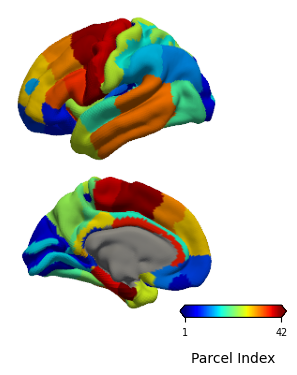

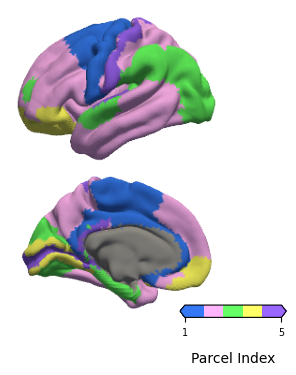

In [57]:
def plot_brain(data2plot, surface_file, hemisphere='lh', title=None,
               cmap='jet', figsize=(6,4), output_dir=None, savefilename_prefix=None, do_percentile=False, save_files = True):
    """
    Plot brain atlas data on cortical surface
    
    Parameters:
    -----------
    data2plot : array
        Data to plot on the surface
    surface_file : str
        Path to surface file (.surf.gii)
    hemisphere : str, default 'lh'
        Hemisphere ('lh' or 'rh')
    title : str
        Title for the plot
    cmap : str, default 'jet'
        Colormap to use
    figsize : tuple, default (6,4)
        Figure size
    output_dir : str, optional
        Directory to save outputs. If None, no files are saved
    filename_prefix : str, default 'von_ek_atlas'
        Prefix for saved files
    
    Returns:
    --------
    fig : matplotlib figure
        The created figure
    """
    plotter = yaspy.Plotter(surface_file, hemi=hemisphere)
    overlay = plotter.overlay(data2plot, cmap=cmap)

    # Generate multi-view montage
    views = ['lateral','medial']
    screenshots = [plotter.screenshot(view) for view in views]
    montage = yaspy.montage([[screenshots[0]],[screenshots[1]]], pad=8)
    
    # Create and style figure
    fig, ax = plt.subplots(figsize=figsize)
    for spine in ax.spines.values():
        spine.set_visible(False)
    plt.imshow(montage)
    plt.title(title)
    plt.axis('off')
    if do_percentile:
        vmin = np.percentile(data2plot, 5)
        vmax = np.percentile(data2plot, 95)
    else:
        vmin = np.nanmin(data2plot)
        vmax = np.nanmax(data2plot)
    # Add colorbar
    cax = ax.inset_axes([0.8, 0, 0.50, 0.04])
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])
    cbar = plt.colorbar(sm, cax=cax, orientation="horizontal", extend='both')
    cbar.set_label('Parcel Index', rotation=0, labelpad=10)
    cbar.set_ticks([np.nanmin(data2plot), np.nanmax(data2plot)])
    cbar.ax.tick_params(labelsize="x-small")
    

    if save_files:
        # Save outputs if directory specified
        if output_dir is not None:
            if not os.path.exists(output_dir):
                os.makedirs(output_dir)
            plt.savefig(f'{output_dir}/{savefilename_prefix}.png', dpi=300)
            np.save(f'{output_dir}/{savefilename_prefix}_32k_fs_LR.npy', data2plot)
    
    return fig

hemi = 'lh'
# Use the function
if hemi == 'lh':
    surface_file = '/Users/dennis.jungchildmind.org/Downloads/MYATLAS_package_new/cortical_surface/conte69_32k/S1200.L.pial_MSMAll.32k_fs_LR.surf.gii'
elif hemi == 'rh':
    surface_file = '/Users/dennis.jungchildmind.org/Downloads/MYATLAS_package_new/cortical_surface/conte69_32k/S1200.R.pial_MSMAll.32k_fs_LR.surf.gii'
data2plot = von_ek_atlas.copy()
datamask = von_ek_atlas > 0
data2plot[~datamask] = np.nan
fig = plot_brain(data2plot, surface_file, hemisphere=hemi,
                 output_dir='von_ek_atlas', savefilename_prefix='von_ek_atlas',save_files=False)

data2plot = economo_koskinas_atlas_rh.copy().astype(float)
datamask = economo_koskinas_atlas_rh > 0
data2plot[~datamask] = np.nan



discrete_cmap = ListedColormap(CYTO5_COLORS .values())

fig2 = plot_brain(data2plot, surface_file, hemisphere=hemi,
                 output_dir='von_ek_atlas', savefilename_prefix='von_ek_atlas',save_files=False, do_percentile=False, cmap=discrete_cmap)


In [58]:
def load_intensity_data(base_path, base_path_intensity, hemisphere='lh', layer='inf', data_type="diff"):
    """
    Load intensity data for a specified hemisphere
    
    Parameters:
    hemisphere (str): 'lh' or 'rh'
    layer (str): layer specification, default 'inf'
    data_type (str): data type, default "diff"
    
    Returns:
    tuple: (intensity_data_uncut, intensity_data_at_zero, subject_names)
    """
    intensity_data_uncut = []
    intensity_data_at_zero = []
    subject_names = []
   
    method_type = base_path_intensity.split('_')[3]
    print(method_type)
    resolution = base_path_intensity.split('_')[2]
    print(resolution)

    for subjects in os.listdir(base_path):
        #for now skip I54_confidence
        if subjects == 'I54_new_confidence':
            continue
        if subjects:
            print('hemi',hemisphere,'layer',layer,'resolution',resolution)
            intensity_file_path = os.path.join(base_path_intensity, subjects, f"{hemisphere}/{layer}_{resolution}_method0_manual_raw_intensity.npz")
           # print(intensity_file_path)
            if os.path.exists(intensity_file_path):
                # Load intensity data
                data = np.load(intensity_file_path, allow_pickle=True)
                if data_type == 'diff':
                    tmp_dat = np.diff(data['all_values'],axis=0)
                else:
                    tmp_dat = data['all_values']
               # params = data['params']
                dist_array = data['dist_array']

                #at zero should be the last postive number before the negative numbers
                at_zero = np.where(dist_array > 0)[0][-1]
                print('at zero:',at_zero,', dist_array:',dist_array[at_zero])
             
                #tmp_dat = data['all_values'];
                
          
                intensity_data_uncut.append(tmp_dat)
                intensity_data_at_zero.append(tmp_dat[at_zero,:])
                subject_names.append(subjects.replace('_new_confidence',''))
    
    return intensity_data_uncut, intensity_data_at_zero, subject_names

base_path = "/Users/dennis.jungchildmind.org/Desktop/exvivo"
base_path_intensity_120um = "/Users/dennis.jungchildmind.org/Desktop/exvivo_postslurm/output_120um_max_960um_dist_method0"
base_path_intensity_240um = "/Users/dennis.jungchildmind.org/Desktop/exvivo_postslurm/output_240um_max_960um_dist_method0"


# Load data for both hemispheres
DATA_TYPE = 'diff'#diff or raw
lh_intensity_data_uncut_120um, lh_intensity_data_at_zero_120um, lh_subject_names_120um = load_intensity_data(base_path, base_path_intensity_120um, 'lh', data_type=DATA_TYPE)
rh_intensity_data_uncut_120um, rh_intensity_data_at_zero_120um, rh_subject_names_120um = load_intensity_data(base_path, base_path_intensity_120um, 'rh', data_type=DATA_TYPE)

lh_intensity_data_uncut_240um, lh_intensity_data_at_zero_240um, _  = load_intensity_data(base_path, base_path_intensity_240um, 'lh', data_type=DATA_TYPE)
rh_intensity_data_uncut_240um, rh_intensity_data_at_zero_240um, _  = load_intensity_data(base_path, base_path_intensity_240um, 'rh', data_type=DATA_TYPE)


max
120um
hemi lh layer inf resolution 120um
at zero: 7 , dist_array: 0.06
hemi lh layer inf resolution 120um
at zero: 7 , dist_array: 0.06
hemi lh layer inf resolution 120um
at zero: 7 , dist_array: 0.06
hemi lh layer inf resolution 120um
hemi lh layer inf resolution 120um
hemi lh layer inf resolution 120um
hemi lh layer inf resolution 120um
at zero: 7 , dist_array: 0.06
hemi lh layer inf resolution 120um
at zero: 7 , dist_array: 0.06
hemi lh layer inf resolution 120um
at zero: 7 , dist_array: 0.06
hemi lh layer inf resolution 120um
at zero: 7 , dist_array: 0.06
hemi lh layer inf resolution 120um
at zero: 7 , dist_array: 0.06
hemi lh layer inf resolution 120um
hemi lh layer inf resolution 120um
at zero: 7 , dist_array: 0.06
hemi lh layer inf resolution 120um
at zero: 7 , dist_array: 0.06
hemi lh layer inf resolution 120um
hemi lh layer inf resolution 120um
hemi lh layer inf resolution 120um
max
120um
hemi rh layer inf resolution 120um
hemi rh layer inf resolution 120um
hemi rh layer i

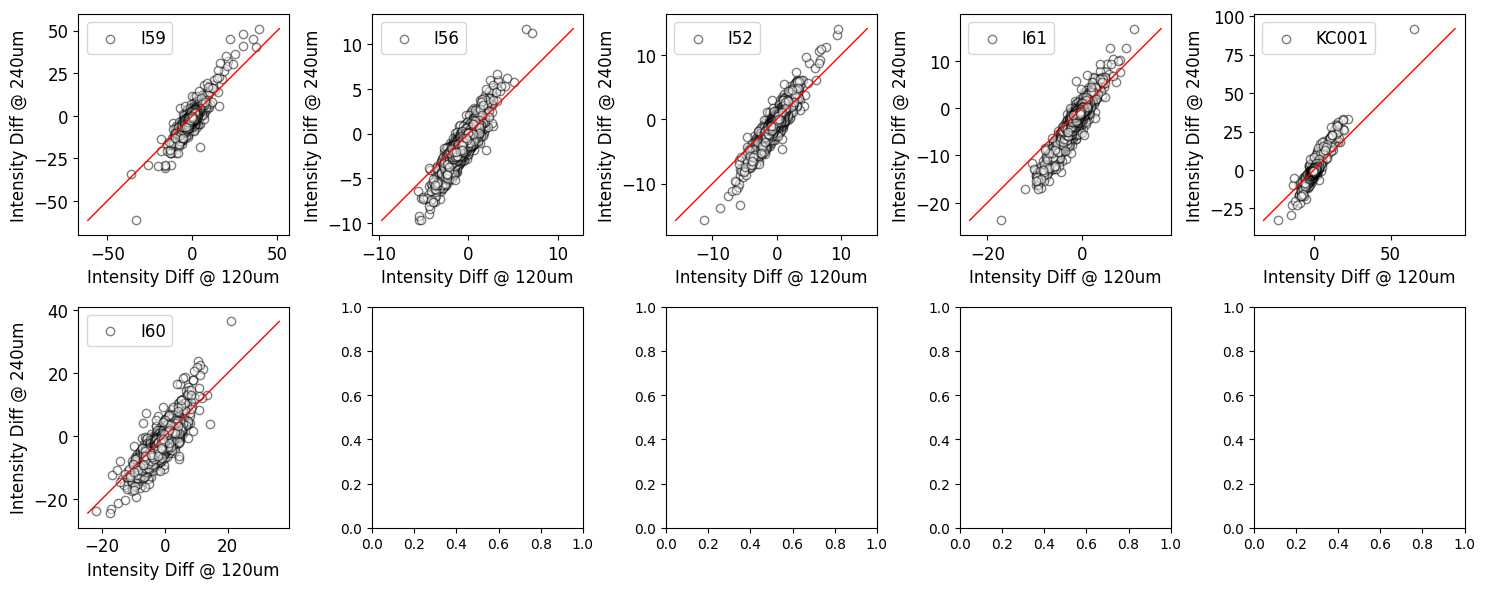

In [59]:
hemi = 'rh'

if hemi == 'lh':
    data1 = lh_intensity_data_at_zero_120um
    data2 = lh_intensity_data_at_zero_240um
    subject_names = lh_subject_names_120um
else:
    data1 = rh_intensity_data_at_zero_120um
    data2 = rh_intensity_data_at_zero_240um
    subject_names = rh_subject_names_120um

num_subjects = len(lh_intensity_data_at_zero_120um)
cols = int(np.ceil(num_subjects / 2))
fig, axes = plt.subplots(2, cols, figsize=(3*cols, 6))
fontsize = 12
# Handle case where there's only one subject
if num_subjects == 1:
    axes = axes.flatten()[:1]
else:
    axes = axes.flatten()

for index in range(num_subjects):
    # Skip if there is no index in the data1
    if index >= len(data1):
        continue
    ax = axes[index]
    ax.scatter(data1[index],data2[index],facecolor='white',edgecolor='black',alpha=0.5,label=subject_names[index])
    ax.legend(fontsize=fontsize)
    #draw x=y line
    min_val = np.min([np.min(data1[index]),np.min(data2[index])])*1
    max_val = np.max([np.max(data1[index]),np.max(data2[index])])*1
    ax.plot([min_val,max_val],[min_val,max_val],'r-',linewidth=1)
    ax.set_xlabel('Intensity Diff @ 120um', fontsize=fontsize)
    ax.set_ylabel('Intensity Diff @ 240um', fontsize=fontsize)
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    ax.axis('equal')

# Hide any unused subplots
for index in range(num_subjects, len(axes)):
    axes[index].set_visible(False)

plt.tight_layout()
plt.show()

In [60]:
#parcellate intensity data based on the von ek atlas
#first get the unique values in the von ek atlas
atlas = von_ek_atlas #von_ek_atlas or economo_koskinas_atlas_lh or economo_koskinas_atlas_rh (should be the same for the latter two)
RESOLUTION = '120um' #120um or 240um
if RESOLUTION == '120um':
    data2use_lh = lh_intensity_data_at_zero_120um #lh_intensity_data_at_zero or lh_intensity_norm_data_at_zero or rh_intensity_data_at_zero or rh_intensity_norm_data_at_zero
    data2use_rh = rh_intensity_data_at_zero_120um #lh_intensity_data_at_zero or lh_intensity_norm_data_at_zero or rh_intensity_data_at_zero or rh_intensity_norm_data_at_zero
elif RESOLUTION == '240um':
    data2use_lh = lh_intensity_data_at_zero_240um #lh_intensity_data_at_zero or lh_intensity_norm_data_at_zero or rh_intensity_data_at_zero or rh_intensity_norm_data_at_zero
    data2use_rh = rh_intensity_data_at_zero_240um #lh_intensity_data_at_zero or lh_intensity_norm_data_at_zero or rh_intensity_data_at_zero or rh_intensity_norm_data_at_zero


unique_values = np.unique(atlas)

#variable for parcellated data
rh_intensity_data_at_zero_parcelled = np.zeros((data2use_rh[0].shape[0], len(data2use_rh)))
rh_intensity_var_at_zero_parcelled = np.zeros((data2use_rh[0].shape[0], len(data2use_rh)))


#iterate for each file
for j, tmp in enumerate(data2use_rh):
    print(tmp.shape)
    #iterate for each parcel
    for i, parcel in enumerate(unique_values):
        indices = np.where(atlas == parcel)[0]
        #grab the data first
        tmp_data = tmp[indices]
        #find standard deviation of the data
        tmp_std = np.nanstd(tmp_data)
        #average the data but for the data that's within 2 std
        tmp_data_within_2std = tmp_data[tmp_data < tmp_std*2]
        tmp_mean = np.nanmean(tmp_data_within_2std)
        tmp_var = np.nanvar(tmp_data_within_2std)
        rh_intensity_data_at_zero_parcelled[indices,j] = tmp_mean
        rh_intensity_var_at_zero_parcelled[indices,j] = tmp_var



lh_intensity_data_at_zero_parcelled = np.zeros((data2use_lh[0].shape[0], len(data2use_lh)))
lh_intensity_var_at_zero_parcelled = np.zeros((data2use_lh[0].shape[0], len(data2use_lh)))

#iterate for each file
for j, tmp in enumerate(data2use_lh):
    print(tmp.shape)
    #iterate for each parcel
    for i, parcel in enumerate(unique_values):
        indices = np.where(atlas == parcel)[0]
        #grab the data first
        tmp_data = tmp[indices]
        #find standard deviation of the data
        tmp_std = np.nanstd(tmp_data)
        #average the data but for the data that's within 2 std
        #tmp_data_within_2std = tmp_data[tmp_data < tmp_std*2]
        tmp_mean = np.nanmean(tmp_data)
        tmp_var = np.nanvar(tmp_data)   
        lh_intensity_data_at_zero_parcelled[indices,j] = tmp_mean
        lh_intensity_var_at_zero_parcelled[indices,j] = tmp_var


(32492,)
(32492,)
(32492,)
(32492,)
(32492,)
(32492,)
(32492,)
(32492,)
(32492,)
(32492,)
(32492,)
(32492,)
(32492,)
(32492,)
(32492,)
(32492,)


In [65]:
print(data_parc.shape)

(32492, 10)


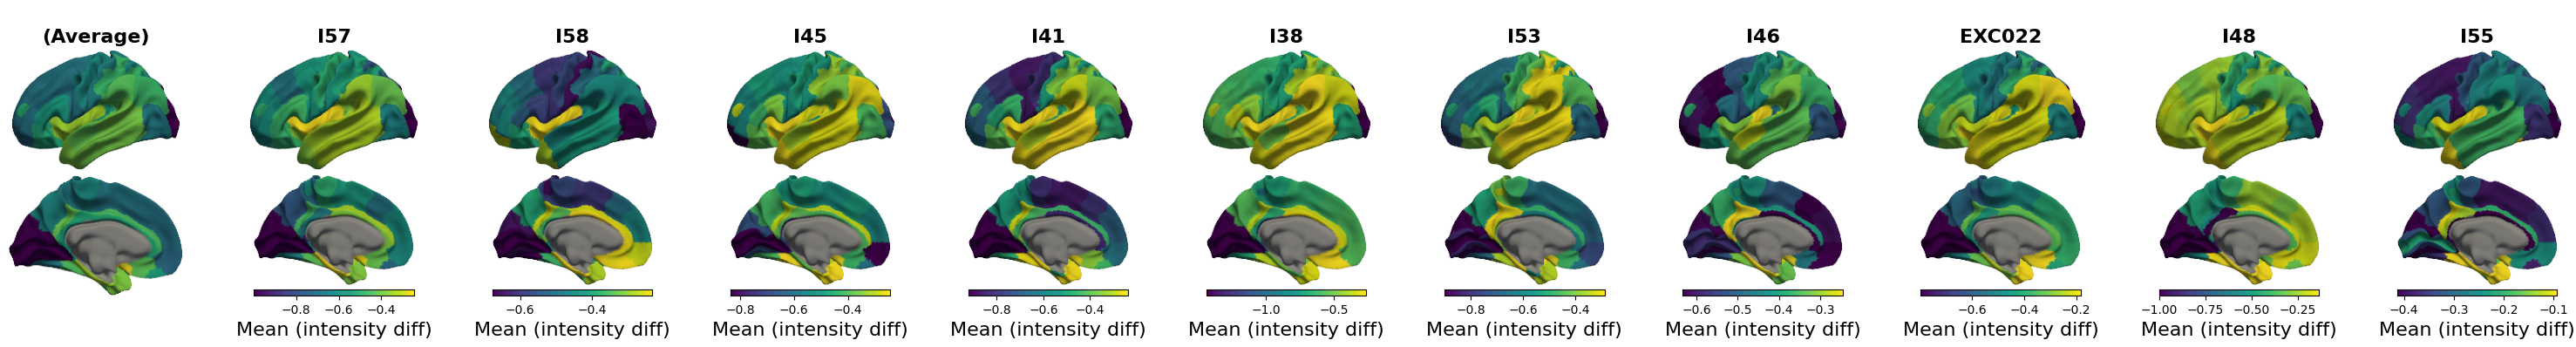

In [67]:


plot_individual_data = True
plot_hemi = 'lh'
data_type = 'mean' #'mean' or 'var'
cmap = 'viridis'
#atlas = von_ek_atlas 
# Surface files and settings
lh_surf = '/Users/dennis.jungchildmind.org/Downloads/HCP_S1200_Atlas_Z4_pkXDZ/S1200.L.white_MSMAll.32k_fs_LR.surf.gii'
rh_surf = '/Users/dennis.jungchildmind.org/Downloads/HCP_S1200_Atlas_Z4_pkXDZ/S1200.R.white_MSMAll.32k_fs_LR.surf.gii'
do_zscore = False

def mask_data(data, atlas_data):
    data_masked = data.copy()
    data_masked[atlas_data == 0] = np.nan
    return data_masked

# Select data based on hemisphere
if plot_hemi == 'lh':
    if data_type == 'mean':
        data_parc = lh_intensity_data_at_zero_parcelled
        clabel = 'Mean (intensity diff)'
    elif data_type == 'var':
        data_parc = lh_intensity_var_at_zero_parcelled
        clabel = 'Var (intensity diff)'
    surf2plot = lh_surf
    subject_names = lh_subject_names_120um
elif plot_hemi == 'rh':
    if data_type == 'mean':
        data_parc = rh_intensity_data_at_zero_parcelled
        clabel = 'Mean (intensity diff)'
    elif data_type == 'var':
        data_parc = rh_intensity_var_at_zero_parcelled
        clabel = 'Var (intensity diff)'
    surf2plot = rh_surf
    subject_names = rh_subject_names_120um

num_cols = lh_intensity_data_at_zero_parcelled.shape[1]#use the one with the higher number of sujbects (lh or rh)

#just create one plotter and reuse when overlay
plotter = yaspy.Plotter(surf2plot, hemi=plot_hemi)

 #economo_koskinas_atlas_rh
if plot_individual_data:
    #perform standardization on the data_parc before averaging using zscore
   
    if do_zscore:
        data_parc_zscore = zscore(data_parc, axis=0, nan_policy='omit')
        data2plot_avg = np.nanmedian(data_parc_zscore,axis=1)
    else:
        data2plot_avg = np.nanmedian(data_parc,axis=1)

    #economo_koskinas_atlas_rh
    data2plot_sub = data_parc


    # economo_koskinas_atlas_rh
    num_sub = data2plot_sub.shape[1]
    # Create figure with 2 rows (lateral/medial) and 1 + num_sub columns (avg + 11 raw)
    fig, axes = plt.subplots(2, 1+num_cols, figsize=(30, 4))
    
    
    # Calculate global min/max for this key across all data points
    all_data = np.concatenate([data2plot_avg[data2plot_avg != 0].flatten()])
    data_min = np.nanpercentile(all_data[~np.isnan(all_data)], 5)
    data_max = np.nanpercentile(all_data[~np.isnan(all_data)], 95)
# 
    # Plot average data (first column)
    data_masked = mask_data(data2plot_avg, atlas)
    
    for view_idx, view in enumerate(['lateral', 'medial']):
        #plotter = yaspy.Plotter(surf2plot, hemi=plot_hemi)
        #calculate data_min and datA_max of this data only
        plotter.overlay(data_masked, cmap=cmap, alpha=1,
                    vmin=data_min, vmax=data_max)
        plotter.border(data_masked, alpha=0)
        img = plotter.screenshot(view)
        
        axes[view_idx,0].imshow(img)
        axes[view_idx,0].axis('off')
        
        if view_idx == 0:
            axes[view_idx,0].set_title(f"\n(Average)", fontweight='bold',fontsize=16)
        else:
            divider = make_axes_locatable(axes[view_idx,0])
        #remove the colorbar for the averaged zscored data
        ''''
        else:
            divider = make_axes_locatable(axes[view_idx,0])
            cax = divider.append_axes("bottom", size="5%", pad=0.05)
            norm = plt.Normalize(vmin=data_min, vmax=data_max)
            cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), 
                            cax=cax, orientation='horizontal')
            cbar.set_label(clabel,fontsize=16)
        '''

    # Plot raw data (remaining columns)
    for col in range(num_sub):  # Plot all raw data columns
        data_masked = mask_data(data2plot_sub[:,col], atlas[0:32492])
        # Calculate min/max for this individual subject only
        subject_data = data_masked[data_masked != 0]
        data_min = np.nanpercentile(subject_data[~np.isnan(subject_data)], 5)
        data_max = np.nanpercentile(subject_data[~np.isnan(subject_data)], 95)
        
        for view_idx, view in enumerate(['lateral', 'medial']):
            #plotter = yaspy.Plotter(surf2plot, hemi=plot_hemi)
            plotter.overlay(data_masked, cmap=cmap, alpha=1,
                        vmin=data_min, vmax=data_max)
            plotter.border(data_masked, alpha=0)
            img = plotter.screenshot(view)
            
            axes[view_idx,col+1].imshow(img)
            axes[view_idx,col+1].axis('off')
            
            if view_idx == 0:
                axes[view_idx,col+1].set_title(f"{subject_names[col]}", fontweight='bold',fontsize=16) 
            else:
                divider = make_axes_locatable(axes[view_idx,col+1])
                cax = divider.append_axes("bottom", size="5%", pad=0.05)
                norm = plt.Normalize(vmin=data_min, vmax=data_max)
                cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), 
                                cax=cax, orientation='horizontal')
                cbar.set_label(clabel,fontsize=16)

    # Handle empty columns if num_cols > num_sub
    if num_cols > num_sub:
        for col in range(num_sub, num_cols):
            axes[0,col+1].axis('off')
            axes[1,col+1].axis('off')

    plt.tight_layout()
    plt.show()


Mean data shape: (5, 10)
Standard deviation data shape: (5, 10)


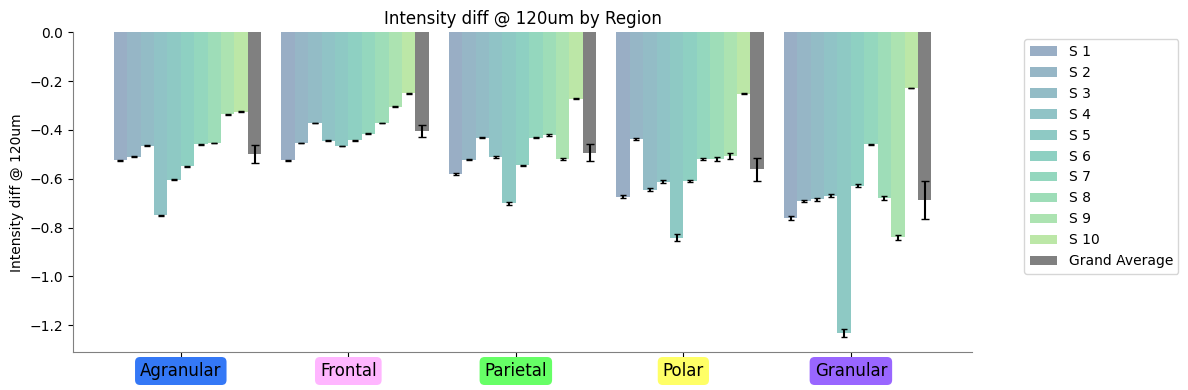

In [68]:
#average within the economo_koskinas_atlas_rh   (economo_koskinas_atlas_lh and _rh are the same)
atlas_to_use = economo_koskinas_atlas_rh
atlas_unique = np.unique(atlas_to_use)[1:]
data2plot_sub_mean = np.zeros((len(atlas_unique),data2plot_sub.shape[1]))
data2plot_sub_std = np.zeros((len(atlas_unique),data2plot_sub.shape[1]))
data2plot_sub_sem = np.zeros((len(atlas_unique),data2plot_sub.shape[1]))
for i in range(data2plot_sub.shape[1]):
    #for each unique parcellation
    for j in range(atlas_unique.shape[0]):
        indices = np.where(atlas_unique[j] == atlas_to_use)[0]
        data2plot_sub_mean[j,i] = np.nanmean(data2plot_sub[indices,i]) 
        data2plot_sub_std[j,i] = np.nanstd(data2plot_sub[indices,i])
        data2plot_sub_sem[j,i] = data2plot_sub_std[j,i] / np.sqrt(len(indices)-1)# sample SEM

print(f"Mean data shape: {data2plot_sub_mean.shape}")
print(f"Standard deviation data shape: {data2plot_sub_sem.shape}")


# Create a minimalistic bar plot
plt.figure(figsize=(12,4))

# Use viridis color palette for subjects
colors = plt.cm.viridis(np.linspace(0.3, 0.8, data2plot_sub_mean.shape[1]))

x_values = np.arange(data2plot_sub_mean.shape[0])
bar_width = 0.8 / data2plot_sub_mean.shape[1]

# Plot bars for each subject
for i in range(data2plot_sub_mean.shape[1]):
    x_offset = x_values + (i - data2plot_sub_mean.shape[1]/2 + 0.5) * bar_width
    plt.bar(x_offset, data2plot_sub_mean[:, i], yerr=data2plot_sub_sem[:, i], 
            width=bar_width, alpha=0.5, capsize=2, 
            color=colors[i], label=f'S {i+1}')

# Calculate and plot grand average
grand_average = np.nanmean(data2plot_sub_mean, axis=1)
grand_sem = np.nanstd(data2plot_sub_mean, axis=1) / np.sqrt(data2plot_sub_mean.shape[1])

x_offset_grand = x_values + (data2plot_sub_mean.shape[1]/2) * bar_width + bar_width/2
plt.bar(x_offset_grand, grand_average, yerr=grand_sem,
         width=bar_width, alpha=1, capsize=3, 
         color='grey', label='Grand Average', zorder=10)

# Styling
plt.ylabel(f'Intensity diff @ {RESOLUTION}')
plt.title(f'Intensity diff @ {RESOLUTION} by Region')

# Clean up spines
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_color('gray')

# Set x-tick labels with colored backgrounds
ax.set_xticks(x_values)
ax.set_xticklabels(CYTO5_NAME, fontsize=12, rotation=0, ha='center')

for i, (tick_label, region_name) in enumerate(zip(ax.get_xticklabels(), CYTO5_NAME)):
    tick_label.set_bbox(dict(boxstyle="round,pad=0.3", 
                            facecolor=CYTO5_COLORS[region_name], alpha=1, edgecolor='none'))

# Add legend
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()